---
# О вкусной и здоровой пище...
---
Проект 3 

## Постановка задачи:
Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import warnings
import random
import re
import math

warnings.simplefilter('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

## Функции для анализа и прогноза

In [14]:
from sklearn.model_selection import train_test_split # специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

rand_seed = 42

def mae_test (dataframe, target = 'rating'):
    X = dataframe.drop([target],axis=1)
    y = dataframe['rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand_seed)


    regr = RandomForestRegressor(n_estimators=100, random_state=rand_seed) # Создаем модель
    regr.fit(X_train, y_train)                     # Тренируем модель
    y_pred = regr.predict(X_test)                  # Предсказываем   

    # Выводим результат сравнения предсказания и теста
    mae = metrics.mean_absolute_error(y_test, y_pred)

    # функция "округления" результата прогноза до 0.5. 
    # так как модель считает до 3 знаков после запятой, точная ошибка будет больше,
    # чем она есть по смыслу (целевая переменная у нас дискретная с шагом 0.5).
    # Таким образом, это округление не читерство!
    def predict_rounder(y_pred):
        return [(round(y/0.5)*0.5) for y in y_pred]
    
    # забираем переменную для округления
    y_pred_rounded = predict_rounder(y_pred)
    
    # результат предсказания теста после окруления реальных результатаов
    mae_r = metrics.mean_absolute_error(y_test, y_pred_rounded)
    
    # рсчет размера окна для вывода графика влияния векторов на итоговый прогноз 
    # (чтобы много места не занимал, когда векторов мало)
    h_ax = len(X.columns)//2 if len(X.columns) < 14 else 7
    
    # вывод графика влияния векторов
    plt.rcParams['figure.figsize'] = (10,h_ax)
    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    
    # возврат значений МАЕ в рузельтат функции
    return mae, mae_r


In [15]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (24, 4))
    sns.boxplot(x=column, y='rating', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index)],
               ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [16]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'rating'], 
                        df.loc[df.loc[:, column] == comb[1], 'rating'], nan_policy='omit').pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [17]:
def dum_on(dataframe, column):
    dum = pd.get_dummies(dataframe[column], prefix=column[:2])
    return dataframe.join(dum)

In [18]:
def test_vector(dataframe, list_to_drop):
    # копируем таблицу и создаем списки векторов
    data = dataframe.copy()
    list_col = data.columns.tolist()                                                    # все векторы
    list_obj = data.select_dtypes(include=['object', 'datetime64']).columns.to_list()   # векторы не числовые
    list_drop = list_to_drop                                                            # векторы для удаления вручную
    
    # создаем итоговый векторов для модели
    list_mae = list(set(list_col) - set(list_obj) - set(list_drop))
    list_mae.remove('rating')
    list_mae.append('rating')                                                           # вектор "рейтинг" ставим в конце
    
    # для удобства отображения делим веткор для модели на части и перобразум в таблицу.
    cut_list = lambda list_mae: [list_mae[i:i+10] for i in range(0, len(list_mae), 10)]
    name_list = lambda nom: ["MAE_"+ str(i) for i in range(0,math.ceil(nom/10))]
    df_mae = pd.DataFrame(cut_list(list_mae)).T
    df_mae.columns = name_list(len(list_mae))
    
    # объединим все векторы в таблицу, чтобы прилично вывести ее на экран и выводим на экран
    show_tab = pd.concat([pd.Series(list_obj, name='object'),
                          pd.Series(list_drop, name='drop'),
                          df_mae], axis=1)
    show_tab.fillna('', inplace=True)
    display(show_tab)
    
    # Вывод на экран значений МАЕ
    mae, mae_round = mae_test(data[list_mae])
    print(f' MAE : {mae}, MAE_rounded: {mae_round}')

In [19]:
def corr_heat(data, list_drop = []):
    # функция построения таблицы-графика корреляции для наглядности
        
    list_col = data.columns.tolist()                                                    # все векторы
    list_obj = data.select_dtypes(include=['object', 'datetime64']).columns.to_list()   # векторы не числовые
    #    list_drop                                                                      # векторы для удаления вручную
    
    # создаем итоговый векторов для модели
    list_mae = list(set(list_col) - set(list_obj) - set(list_drop))
    list_mae = sorted(list_mae)
    list_mae.remove('rating')
    list_mae.append('rating')                                                           # вектор "рейтинг" ставим в конце
   
    # рисование графика 
    cor = data[list_mae].corr()
    plt.figure(figsize=(16,6)) # размер графика
    cm3 = sns.diverging_palette(10, 10, sep=10, center='light', as_cmap=True)
    sns.heatmap(data=cor, annot=True, vmin=-1, vmax=1, center=0, cmap=cm3, linewidths=0.1)
    

- - -  
### 1. Загружаем датасет и форматируем структуру  
- - -   

In [2]:
# Загружаем датасет
df = pd.read_csv('main_task_new.csv')
# Приведем названия колонок к нормальному виду: все буквы строчные, пробелы - заменяем на "_"
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df.rename({'number_of_reviews': 'reviews_num'}, inplace=True, axis=1)  # укорачиваю длинное название с двумя пробелами

#### Векторы  
**restaurant_id** — идентификационный номер ресторана / сети ресторанов;  
**city** — город, в котором находится ресторан;  
**cuisine_style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;  
**ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;  
**rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);  
**price_range** — диапазон цен в ресторане;  
**reviews_num** — количество отзывов о ресторане;  
**reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;  
**url_ta** — URL страницы ресторана на TripAdvisor;  
**id_ta** — идентификатор ресторана в базе данных TripAdvisor.  

In [3]:
# переставлю местами векторы, чтобы было удобнее работать
df = df[['restaurant_id', 'id_ta', 'city', 'cuisine_style', 'price_range', 
         'reviews_num', 'reviews', 'url_ta', 'ranking', 'rating', ]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  40000 non-null  object 
 1   id_ta          40000 non-null  object 
 2   city           40000 non-null  object 
 3   cuisine_style  30717 non-null  object 
 4   price_range    26114 non-null  object 
 5   reviews_num    37457 non-null  float64
 6   reviews        40000 non-null  object 
 7   url_ta         40000 non-null  object 
 8   ranking        40000 non-null  float64
 9   rating         40000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4]:
df.isna().sum()

restaurant_id        0
id_ta                0
city                 0
cuisine_style     9283
price_range      13886
reviews_num       2543
reviews              0
url_ta               0
ranking              0
rating               0
dtype: int64

In [5]:
# В датасете есть три вектора с пропусками. Для начала просто сохраним для информции записи, где они присутствуют
df['no_revies'] = df.reviews_num.apply(pd.isna).astype(np.uint8)
df['no_prices'] = df.price_range.apply(pd.isna).astype(np.uint8)
df['no_styles'] = df.cuisine_style.apply(pd.isna).astype(np.uint8)

- - -  
### 2.1. Два вектора ID  
- - -   
#### Дубликат id_ta  

В датасете есть два вектора с ID номерами. Но нам интересен только один - id_ta. Это код "Трип-Эдвайзера" для ресторана. И он, по идее, должен быть уникальным.  
По опыту своей работы я очень трепетно отношусь ко всякого рода ID. Для меня это - уникальные идентификаторы и дублирование их не допустимо. Если же в векторе, озаглавленном ID, есть дубликаты - это повод очень серьезно задуматься и решить, что с ними делать, чтобы дублей не было.  
Проверим **id_ta**, и выясним, что эти ID дублируюутся!!!

In [6]:
# получим словарь со списком ресторанов, продублированными в датасете
all_codes = df.id_ta.value_counts().to_dict()
codes_ta = {key: all_codes[key] for key in all_codes if all_codes[key] > 1}
codes_ta

{'d13002276': 2,
 'd11698990': 2,
 'd3161682': 2,
 'd697406': 2,
 'd3685055': 2,
 'd11999956': 2,
 'd793170': 2,
 'd11674463': 2,
 'd1315077': 2,
 'd4600226': 2,
 'd10047799': 2,
 'd9802625': 2,
 'd7809594': 2,
 'd987900': 2,
 'd7342803': 2,
 'd8753348': 2,
 'd7337366': 2,
 'd2477531': 2,
 'd9877640': 2,
 'd11921719': 2}

In [7]:
# посмотрим на эти записиси
ddf = df[df.id_ta.isin(codes_ta)]        # датасет только с кодами-дублями трип-эдвайзера 
ddf.sort_values(by=['id_ta']).head(6)

,restaurant_id,id_ta,city,cuisine_style,price_range,reviews_num,reviews,url_ta,ranking,rating,no_revies,no_prices,no_styles
38946,id_3242,d10047799,Madrid,NaN,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,3244.0,5.0,0,1,1
13980,id_3239,d10047799,Madrid,NaN,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,3241.0,5.0,0,1,1
11583,id_3810,d11674463,Madrid,"['American', 'German', 'European', 'Central Eu...",NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,3812.0,4.0,0,1,0
4732,id_3804,d11674463,Madrid,"['American', 'German', 'European', 'Central Eu...",NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,3806.0,4.0,0,1,0
26551,id_3240,d11698990,Madrid,NaN,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,3242.0,4.5,0,1,1
26431,id_3238,d11698990,Madrid,NaN,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,3240.0,4.5,0,1,1


In [8]:
# посмотрим, какая информация в дулях записей дублируется, а какая нет (в таблице - количество уникальных значений)
ddf.groupby('id_ta')[['restaurant_id', 'city','cuisine_style','price_range', 'reviews_num', 'reviews', 'url_ta',
                      'ranking', 'rating', 'no_revies', 'no_prices', 'no_styles']].agg(lambda q: q.nunique())

,restaurant_id,city,cuisine_style,price_range,reviews_num,reviews,url_ta,ranking,rating,no_revies,no_prices,no_styles
id_ta,,,,,,,,,,,,
d10047799,2,1,0,0,1.0,1,1,2.0,1.0,1,1,1
d11674463,2,1,1,0,1.0,1,1,2.0,1.0,1,1,1
d11698990,2,1,0,0,1.0,1,1,2.0,1.0,1,1,1
d11921719,2,1,0,0,1.0,1,1,2.0,1.0,1,1,1
d11999956,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1
d13002276,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1
d1315077,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1
d2477531,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1
d3161682,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1


Два значения - это то, чем записи отличаются (**restaurant_id**,**ranking**). И судя по всему, эти дубликаты - смена рестораном собственника, что повлекло смену кода-ресторана и рейтинга.

In [9]:
# словарь с кодами-ресторанов в датасете где с кодами-дублями трип-эдвайзера 
all_codes_r = ddf.restaurant_id.value_counts().to_dict()       
codes_ta_r = {key: all_codes_r[key] for key in all_codes_r}
len(codes_ta_r)

40

In [10]:
# словарь с дублями кодов-ресторанов в оригинале датасета
rest_all_codes = df.restaurant_id.value_counts().to_dict()
rest_codes = {key: rest_all_codes[key] for key in rest_all_codes if rest_all_codes[key] > 1}     # выбираем сетевые рестораны

# сравниваем списки и выясняем, что в 18 из 20 случаев, ресторан был выкуплен сетью. 
# Еще в дух случаях - просто сменил собственника
len(set(rest_codes) & set(codes_ta_r))

36

#### Вывод
Пофакту исследования делаю вывод, что дубликаты **id_ta** вызваны тем, что в датасет попала временнAя динамика ресторанов, скорее всего, рестораны были перепроданы, чаще всего - в сетевую структуру. В связи с чем, с начала  был один рейтинг, а после он изменился (встречается и рост и падение). При этом, надо отметить, что записи идентичны во всех без исключения остальных векторах.  

*Таким образом, я принимаю решение, что запись с бОльшим индексом - более "позняя" и именно ее ранг я должен использовать, а "ранние" нужно исключить из датасета. Несмотря на то, что удаление строк в принципе не являестя допустимым с точки зрения выполнения задания.*

In [11]:
# удалеляем дубликаты записей с одинкавым **id_ta**, осатавив "последний" по номеру, считая
# что это будет более позний по дате установления.
df.drop_duplicates('id_ta', keep='last', inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  39980 non-null  object 
 1   id_ta          39980 non-null  object 
 2   city           39980 non-null  object 
 3   cuisine_style  30701 non-null  object 
 4   price_range    26101 non-null  object 
 5   reviews_num    37437 non-null  float64
 6   reviews        39980 non-null  object 
 7   url_ta         39980 non-null  object 
 8   ranking        39980 non-null  float64
 9   rating         39980 non-null  float64
 10  no_revies      39980 non-null  uint8  
 11  no_prices      39980 non-null  uint8  
 12  no_styles      39980 non-null  uint8  
dtypes: float64(3), object(7), uint8(3)
memory usage: 3.5+ MB


#### Интегрирование id_ta

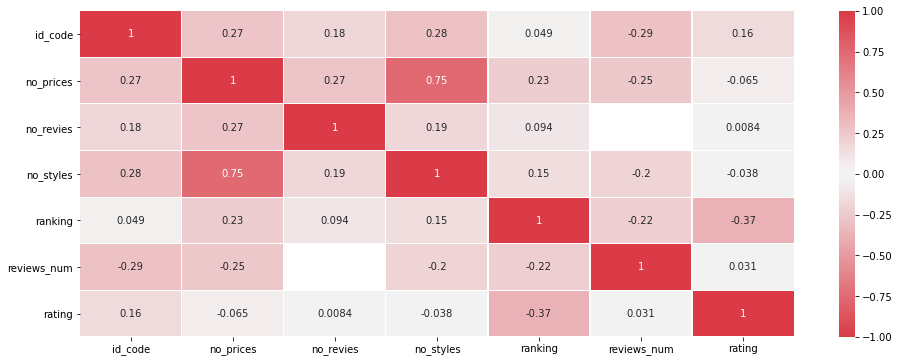

In [20]:
# удалим из кода букву 
df['id_code']=pd.to_numeric(df.id_ta.str.strip('d'))
corr_heat(df)
#= pd.to_numeric(df.id_code)

#### Итог
У **id_code** хорошая перспектива полезности для модели. И эта история для меня весьма странная!.. Но, этьо не помешает использовать найденный фактор.
У него есть заметная корреляция с другими, в т.ч. техническими, векторами, но с этим мы разберемся позже.

- - -  
### 2.2. Вектор Country
- - -  
Добавим вектор "Страна", для возможной аггрегации в последствии. Для этого создадим словарь в ручную и используем его для заполнения значениемями вектора.

In [21]:
countries = {      'Paris': 'France', 
               'Stockholm': 'Sweden',
                  'London': 'United Kingdom', 
                  'Berlin': 'Germany', 
                  'Munich': 'Germany',
                 'Oporto' : 'Portugal' ,
                  'Milan' : 'Italy',
             'Bratislava' : 'Slovakia',
                 'Vienna' : 'Austria' ,
                    'Rome': 'Italy',
              'Barcelona' : 'Spain',
                 'Madrid' : 'Spain',
                 'Dublin' : 'Ireland',
               'Brussels' : 'Belgium',
                 'Zurich' : 'Switzerland',
                 'Warsaw' : 'Poland',
               'Budapest' : 'Hungary',
             'Copenhagen' : 'Denmark',
              'Amsterdam' : 'Netherlands',
                   'Lyon' : 'France',
                'Hamburg' : 'Germany',
                 'Lisbon' : 'Portugal',
                 'Prague' : 'Czech Republic',
                   'Oslo' : 'Norway',
               'Helsinki' : 'Finland',
              'Edinburgh' : 'United Kingdom',
                 'Geneva' : 'Switzerland',
              'Ljubljana' : 'Slovenia',
                 'Athens' : 'Greece',
             'Luxembourg' : 'Luxembourg' ,
                  'Krakow': 'Poland'
            }

In [22]:
# создадим новый вектор и поставим его по порядку после вектора "город"
df['country'] = df.city.map(countries)
df = df[['restaurant_id', 'id_ta', 'city', 'country', 'cuisine_style', 'price_range',
       'reviews_num', 'reviews', 'url_ta', 'ranking', 'rating', 'no_revies',
       'no_prices', 'no_styles', 'id_code']]

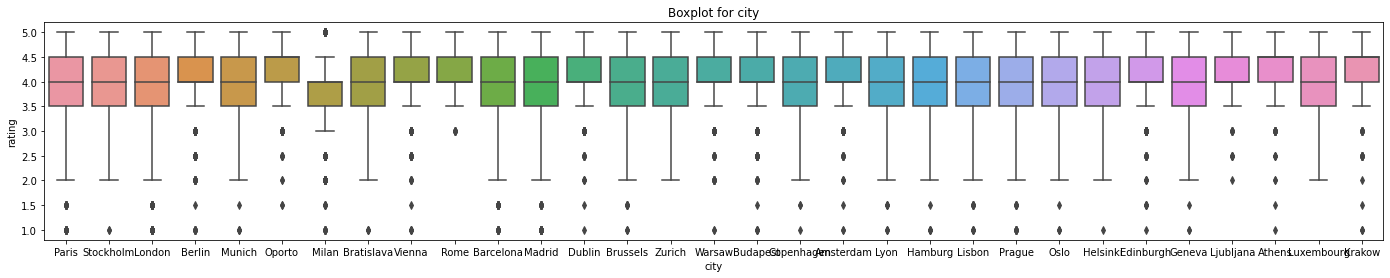

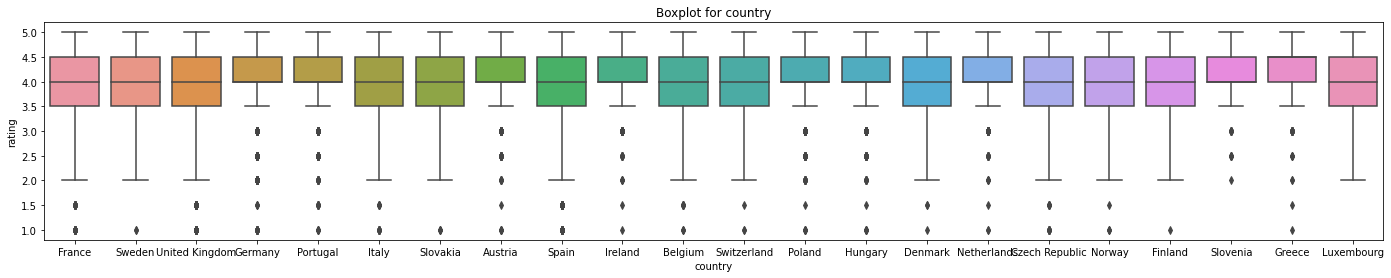

In [23]:
for col in [ 'city', 'country']:
    get_boxplot(col)

In [24]:
for col in [ 'city', 'country']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки country


Два ординарных вектора показывают потенциальную полезность для модели. Проверим позже...

- - - -
### 2.3. Вектор cuisine_style, новый вектор cuisines, заполнение пропусков и FE
- - - -
В этом векторе есть пропуски. Но, для начала, перобразуем данные в полях вектора в списки. Затем, проанализиреум список всех уникальных кухонь. И предлагаю заполнить пропуски в полях теми кухнями, которые являются самыми частыми в этом городе.  

In [25]:
# преобразуем строку из признкака "cuisine_style" в список из названий 
df.cuisine_style = df.cuisine_style.str.replace("'", "")
df.cuisine_style = df.cuisine_style.str.strip('[]')
df.cuisine_style = df.cuisine_style.str.split(', ')

In [26]:
# количество уникальных кухонь (надо отнять 1 так как в списке есть и пропуск, где кухни не заполнены)
len(df.cuisine_style.explode().unique())-1

125

In [27]:
# создадим новый вектор с данным о количестве кухонь. и поместим его перед вектором со списокм кухонь
df.cuisine_style.fillna('', inplace=True)
df['cuisines'] = df.cuisine_style.apply(lambda x: 0 if x =='' else len(x))
df = df[['restaurant_id', 'id_ta', 'id_code', 'city', 'country', 'cuisines', 'cuisine_style',
       'price_range', 'reviews_num', 'reviews', 'url_ta', 'ranking', 'rating',
       'no_revies', 'no_prices', 'no_styles']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  39980 non-null  object 
 1   id_ta          39980 non-null  object 
 2   id_code        39980 non-null  int64  
 3   city           39980 non-null  object 
 4   country        39980 non-null  object 
 5   cuisines       39980 non-null  int64  
 6   cuisine_style  39980 non-null  object 
 7   price_range    26101 non-null  object 
 8   reviews_num    37437 non-null  float64
 9   reviews        39980 non-null  object 
 10  url_ta         39980 non-null  object 
 11  ranking        39980 non-null  float64
 12  rating         39980 non-null  float64
 13  no_revies      39980 non-null  uint8  
 14  no_prices      39980 non-null  uint8  
 15  no_styles      39980 non-null  uint8  
dtypes: float64(3), int64(2), object(8), uint8(3)
memory usage: 4.4+ MB


In [28]:
# Среднее значение числа "кухонь" на одно заведение - почти 2.4
df.cuisines.mean()
# Значит, надо будет заполнить не одной какой-то кухней, а как минимум двумя

2.390295147573787

In [29]:
# список всех уникальных кухонь
cuisines_all = df.cuisine_style.explode().sort_values().unique()
cuisines_all

array(['', 'Afghani', 'African', 'Albanian', 'American', 'Arabic',
       'Argentinean', 'Armenian', 'Asian', 'Australian', 'Austrian',
       'Azerbaijani', 'Balti', 'Bangladeshi', 'Bar', 'Barbecue',
       'Belgian', 'Brazilian', 'Brew Pub', 'British', 'Burmese', 'Cafe',
       'Cajun & Creole', 'Cambodian', 'Canadian', 'Caribbean',
       'Caucasian', 'Central American', 'Central Asian',
       'Central European', 'Chilean', 'Chinese', 'Colombian',
       'Contemporary', 'Croatian', 'Cuban', 'Czech', 'Danish',
       'Delicatessen', 'Diner', 'Dutch', 'Eastern European', 'Ecuadorean',
       'Egyptian', 'Ethiopian', 'European', 'Fast Food', 'Filipino',
       'French', 'Fujian', 'Fusion', 'Gastropub', 'Georgian', 'German',
       'Gluten Free Options', 'Greek', 'Grill', 'Halal', 'Hawaiian',
       'Healthy', 'Hungarian', 'Indian', 'Indonesian', 'International',
       'Irish', 'Israeli', 'Italian', 'Jamaican', 'Japanese', 'Korean',
       'Kosher', 'Latin', 'Latvian', 'Lebanese', 'Ma

In [30]:
# самая популярная кухня
df.cuisine_style.explode().value_counts().index[0], df.cuisine_style.explode().value_counts()[0]
# ('Vegetarian Friendly', 11183)

df.cuisine_style.explode().value_counts().iloc[:40]
# 

Vegetarian Friendly    11183
European               10056
                        9279
Mediterranean           6271
Italian                 5963
Vegan Options           4482
Gluten Free Options     4110
Bar                     3296
French                  3189
Asian                   3010
Pizza                   2849
Spanish                 2788
Pub                     2449
Cafe                    2325
Fast Food               1705
British                 1595
International           1583
Seafood                 1504
Japanese                1463
Central European        1392
American                1312
Sushi                   1156
Chinese                 1145
Portuguese              1107
Indian                  1041
Middle Eastern           781
Thai                     743
Wine Bar                 697
German                   661
Healthy                  620
Greek                    604
Halal                    597
Czech                    595
Fusion                   577
Steakhouse    

Переходим к заполнению полей вектора **cuisine_style** в соответстивии с планом. Замечу, что можно было бы затеять более сложный анализ для восстановления этих пропущенных данных. Я обратил внимание, что некоторые отзывы у таких записей содержат намеки на вид кухни ресторана, но такие сведения единичны.
По вектору "город" выберем наиболее частые кухни и заполним этими значениями пропуски.

Хочу отметить, что в списке кухонь есть как, собственно, виды кухонь (национальные, или региональные), так и сервисы или подходы к приготовлению еды (вегетарианская, безглютеновая, веганская, халяль, кошерная), которые можно условно назвать "здоровая" еда, а также можно найти типы заведений, не совсем "рестораны": бар, кафе, пиццерия, закусочная.  
Попробую корректно разделить их в последуюущем

In [31]:
# Создадим словарь из наиболее частых видов кухонь по городам, где это поле заполнено,
#  чтобы заполнить таким жеобразом пропуски
cusines_fill=dict()
for city in df.city.unique():
    temp_dict = df[df.city == city].cuisine_style.explode().value_counts()[:3].to_dict()
    if '' in temp_dict:
        temp_dict.pop('')
    value = list(temp_dict.keys())
    cusines_fill[city]=value
        
cusines_fill

{'Paris': ['French', 'European', 'Vegetarian Friendly'],
 'Stockholm': ['European', 'Vegetarian Friendly'],
 'London': ['Vegetarian Friendly', 'British', 'Gluten Free Options'],
 'Berlin': ['Vegetarian Friendly', 'European'],
 'Munich': ['Vegetarian Friendly', 'European'],
 'Oporto': ['European', 'Portuguese', 'Mediterranean'],
 'Milan': ['Italian', 'Vegetarian Friendly'],
 'Bratislava': ['European', 'Central European'],
 'Vienna': ['European', 'Vegetarian Friendly', 'Austrian'],
 'Rome': ['Italian', 'Vegetarian Friendly', 'Mediterranean'],
 'Barcelona': ['Spanish', 'Mediterranean', 'Vegetarian Friendly'],
 'Madrid': ['Spanish', 'Mediterranean'],
 'Dublin': ['Vegetarian Friendly', 'European', 'Irish'],
 'Brussels': ['European', 'Belgian'],
 'Zurich': ['Vegetarian Friendly', 'European'],
 'Warsaw': ['European', 'Vegetarian Friendly'],
 'Budapest': ['European', 'Hungarian', 'Vegetarian Friendly'],
 'Copenhagen': ['European', 'Vegetarian Friendly'],
 'Amsterdam': ['European', 'Vegetarian 

In [32]:
# создаю временный вектор с данными подстановки из словаря
df['cuisines_l'] = df.city.map(cusines_fill)     
# собираю сведения о кухне из двух векторов в один оригинальный
df['cuisine_style'] = df.apply(lambda q: q['cuisines_l'] if q['no_styles'] == 1 else q['cuisine_style'] , axis=1)
#  заменяю 0 на 1 количества кухонь в векторе в соответствии с тем, что теперь там по 1 кухне есть точно
df.cuisines = df.cuisines.replace(0,3)
# Удаляю временный вектор
df.drop(['cuisines_l'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  39980 non-null  object 
 1   id_ta          39980 non-null  object 
 2   id_code        39980 non-null  int64  
 3   city           39980 non-null  object 
 4   country        39980 non-null  object 
 5   cuisines       39980 non-null  int64  
 6   cuisine_style  39980 non-null  object 
 7   price_range    26101 non-null  object 
 8   reviews_num    37437 non-null  float64
 9   reviews        39980 non-null  object 
 10  url_ta         39980 non-null  object 
 11  ranking        39980 non-null  float64
 12  rating         39980 non-null  float64
 13  no_revies      39980 non-null  uint8  
 14  no_prices      39980 non-null  uint8  
 15  no_styles      39980 non-null  uint8  
dtypes: float64(3), int64(2), object(8), uint8(3)
memory usage: 4.4+ MB


#### Расшифровка типов заведений
 ----------------------------
 * bar     - бар, заведение, где преймущественно пьют  
 * cafe    - кафе, заведение, не "доросшее" до ресторана по каким-то причинам, или с какой-то специализацией (десертная, стйк, рыба), также , заведение, где преймущественно быстрая, уличная еда или типа столовой  
 * helthy - список опций для здорового или "правильного" питания  
 * .. - если в списке кухонь нет вышеперечисленных - буду считать задение рестораном  
 
 PS поправочка. Практически ничего с таким разделением я сделать не смог, так что почти все пришлось удалять. Почти, но, не все...
 

In [33]:
#types_bar = ['Bar','Brew Pub', 'Wine Bar', 'Pub']
#types_dinner = ['Diner', 'Pizza', 'Fast Food', 'Soups','Street Food', 'Barbecue', 'Grill']
types_cafe = ['Cafe', 'Gastropub', 'Delicatessen','Steakhouse', 'Sushi', 'Diner', 'Pizza', 
              'Fast Food', 'Soups','Street Food', 'Barbecue', 'Grill', 'Bar','Brew Pub', 'Wine Bar', 'Pub']
types_cuis = ['Afghani', 'African', 'Albanian', 'American', 'Arabic', 'Argentinean', 'Armenian',
              'Asian', 'Australian', 'Austrian', 'Azerbaijani', 'Balti', 'Bangladeshi','Belgian',
              'Brazilian', 'British', 'Burmese', 'Cajun & Creole', 'Cambodian', 'Canadian', 
              'Caribbean','Caucasian', 'Central American', 'Central Asian', 'Central European',
              'Chilean', 'Chinese', 'Colombian', 'Contemporary', 'Croatian', 'Cuban', 'Czech', 
              'Danish', 'Dutch', 'Eastern European', 'Ecuadorean','Egyptian', 'Ethiopian', 
              'European', 'Filipino', 'French', 'Fujian', 'Fusion', 'Georgian', 'German', 'Greek',
              'Hawaiian', 'Hungarian', 'Indian', 'Indonesian', 'International','Irish', 'Israeli',
              'Italian', 'Jamaican', 'Japanese', 'Korean', 'Latin', 'Latvian', 'Lebanese', 
              'Malaysian','Mediterranean', 'Mexican', 'Middle Eastern', 'Minority Chinese',
              'Mongolian', 'Moroccan', 'Native American', 'Nepali', 'New Zealand', 'Norwegian', 
              'Pakistani', 'Persian', 'Peruvian', 'Polish', 'Polynesian', 'Portuguese', 'Romanian',
              'Russian', 'Salvadoran', 'Scandinavian', 'Scottish', 'Seafood', 'Singaporean', 
              'Slovenian', 'South American','Southwestern', 'Spanish', 'Sri Lankan', 'Swedish',
              'Swiss', 'Taiwanese', 'Thai', 'Tibetan', 'Tunisian', 'Turkish', 'Ukrainian', 
              'Uzbek','Venezuelan', 'Vietnamese', 'Welsh', 'Xinjiang', 'Yunnan']
helthy_option = ['Gluten Free Options', 'Halal', 'Healthy' 'Kosher', 'Vegan Options', 'Vegetarian Friendly']
junk_food = ['Fast Food', 'Street Food', 'Barbecue', 'Grill']

In [34]:
# здесь должна была быть функция 
def set_cuisines(row):
    if len(row.cuisine_style) != 0:
        temp = row.cuisine_style
        cuis = len(set(temp)&set(types_cuis))
        cafe = len(set(temp)&set(types_cafe))
#        bar = len(set(temp)&set(types_bar))
        helthy = len(set(temp)&set(helthy_option))
        junk = len(set(temp)&set(junk_food))
        return [cuis, cafe, helthy, junk]
    return [0,0,0,0]

In [35]:
df[['rest_var', 'cafe', 'helthy', 'junk']] = df.apply(set_cuisines,axis=1, result_type = 'expand')

In [36]:
#df.drop('bar', axis=1, inplace=True)
df = df[['restaurant_id', 'id_ta', 'id_code', 'city', 'country', 'cuisines', 'rest_var',
       'cafe', 'helthy', 'junk', 'cuisine_style', 'price_range', 'reviews_num', 'reviews', 
         'url_ta', 'ranking', 'rating', 'no_revies', 'no_prices', 'no_styles']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  39980 non-null  object 
 1   id_ta          39980 non-null  object 
 2   id_code        39980 non-null  int64  
 3   city           39980 non-null  object 
 4   country        39980 non-null  object 
 5   cuisines       39980 non-null  int64  
 6   rest_var       39980 non-null  int64  
 7   cafe           39980 non-null  int64  
 8   helthy         39980 non-null  int64  
 9   junk           39980 non-null  int64  
 10  cuisine_style  39980 non-null  object 
 11  price_range    26101 non-null  object 
 12  reviews_num    37437 non-null  float64
 13  reviews        39980 non-null  object 
 14  url_ta         39980 non-null  object 
 15  ranking        39980 non-null  float64
 16  rating         39980 non-null  float64
 17  no_revies      39980 non-null  uint8  
 18  no_pri

In [37]:
df.drop(['cafe', 'junk'], axis=1, inplace=True)

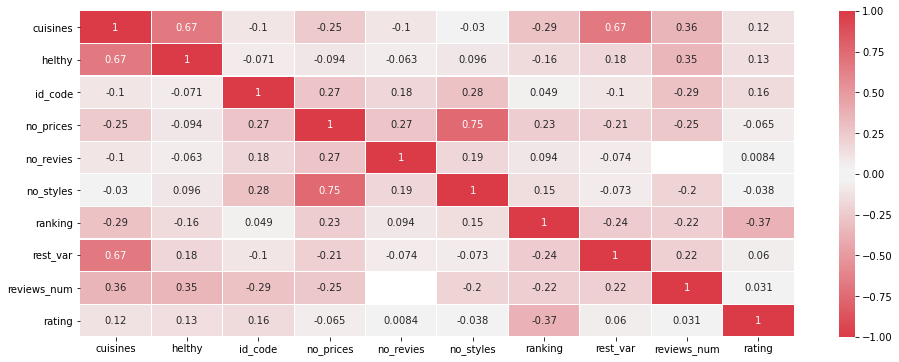

In [38]:
corr_heat(df)

Несмотря на все мои усилия, никакие манипуляции с вектором не принесли существенных результатов, за исключением вектора "helthy", который имеет лучшую корреляцию с рейтнгом (0,13) по сравнению с исходным вектором "cuisines" (количество кухонь всего). Также я пока оставлю вектор "rest_var", несмотря на то, что окореляция у него низкая и улучшить ее я тоже не смог.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  39980 non-null  object 
 1   id_ta          39980 non-null  object 
 2   id_code        39980 non-null  int64  
 3   city           39980 non-null  object 
 4   country        39980 non-null  object 
 5   cuisines       39980 non-null  int64  
 6   rest_var       39980 non-null  int64  
 7   helthy         39980 non-null  int64  
 8   cuisine_style  39980 non-null  object 
 9   price_range    26101 non-null  object 
 10  reviews_num    37437 non-null  float64
 11  reviews        39980 non-null  object 
 12  url_ta         39980 non-null  object 
 13  ranking        39980 non-null  float64
 14  rating         39980 non-null  float64
 15  no_revies      39980 non-null  uint8  
 16  no_prices      39980 non-null  uint8  
 17  no_styles      39980 non-null  uint8  
dtypes: flo

 - - -  
### 2.4. Вектор price_range  
 - - -  
Мы одновременно преобразуем векор в ординальный вид и заменим пропуск на 2, так как это средний ценовой диапазон, встечающийся чаще всего

In [40]:
# создание нового поля и заполнение пропусков значением 2 (медиана ценовой категории = 2, среднее = 1,88)
df['price_'] = df.price_range.apply(lambda p: 3 if p == '$$$$' else 2 if  p == '$$ - $$$' else 1 if p == '$' else 2)
# "кузнец больше не нужен"
df.drop(['price_range'], axis=1, inplace=True)

In [41]:
df = df[['restaurant_id', 'id_ta', 'id_code', 'city', 'country', 'cuisines',
       'rest_var', 'helthy', 'cuisine_style', 'price_', 'reviews_num', 'reviews',
       'url_ta', 'ranking', 'rating', 'no_revies', 'no_prices', 'no_styles']]

In [42]:
# преобразуем вектор price_ - возьмем логарифм - так корреляция увеличивается в 1,5 раза
df['price_log2'] = np.log2(df.price_)
df['price_log'] = np.log(df.price_)

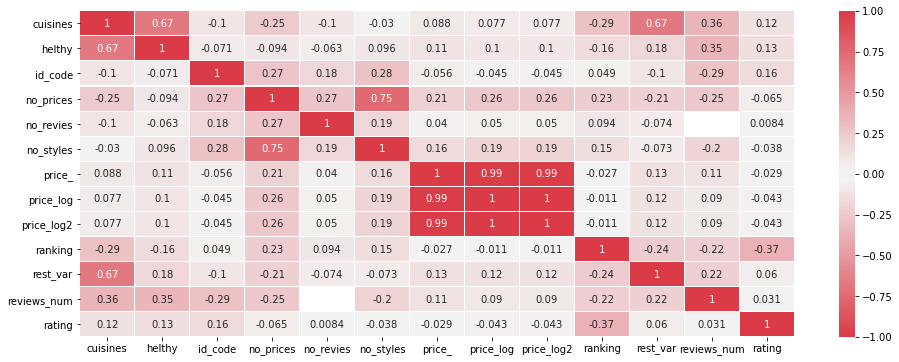

In [43]:
corr_heat(df)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  39980 non-null  object 
 1   id_ta          39980 non-null  object 
 2   id_code        39980 non-null  int64  
 3   city           39980 non-null  object 
 4   country        39980 non-null  object 
 5   cuisines       39980 non-null  int64  
 6   rest_var       39980 non-null  int64  
 7   helthy         39980 non-null  int64  
 8   cuisine_style  39980 non-null  object 
 9   price_         39980 non-null  int64  
 10  reviews_num    37437 non-null  float64
 11  reviews        39980 non-null  object 
 12  url_ta         39980 non-null  object 
 13  ranking        39980 non-null  float64
 14  rating         39980 non-null  float64
 15  no_revies      39980 non-null  uint8  
 16  no_prices      39980 non-null  uint8  
 17  no_styles      39980 non-null  uint8  
 18  price_

- - -  
### 2.5. Вектор "reviews" и "reviews_num"
- - -  

In [45]:
df[(df.reviews_num > 0) & (df.reviews == '[[], []]')][['reviews_num', 'reviews']]

,reviews_num,reviews
3,3.0,"[[], []]"
10,6.0,"[[], []]"
14,7.0,"[[], []]"
25,2.0,"[[], []]"
29,16.0,"[[], []]"
...,...,...
39975,3.0,"[[], []]"
39976,13.0,"[[], []]"
39981,29.0,"[[], []]"
39991,5.0,"[[], []]"


В датасете неоднозначно заполнены схожие по смыслу поля **reviews_num** и **reviews**. Таблица распределения ниже.  
Бросается в глаза, что в **reviews_num** нет 0 и 1, тогда как поле **reviews** может быть не заполнено, или иметь 1 отзыв. С другой стороны, **reviews_num** может быть заполнено числом, но отзывов самих в соседнем поле нет. А может иметь число большее, чем 1, тем не менее, сам отзыв будет только один.  

reviews_num | reviews | количество записей | Описание
:--- |:--- |:---: |:---
NaN  | '[[], []]' | 1597 | "Количество" не заполнено, и самих отзывов нет - **все совпадает**
NaN  | отзывы  | 946 | "Количество" не заполнено, но сами отзывы есть - **НЕ совпадает**
 \>1 | '[[], []]' | 4868 | Есть не нулевое "Количество" отзывов, но самих отзывов не указано - тоже **НЕ совпадает**
2...986 | 1 отзыв | 4554 | Есть "количество" отзывов, большее 1, но отзыв приведен только один - по-прежнему **НЕ совпадает**
2...9660 | 2 отзыва | 28961 | Ну, и все остальное, где смысл не нарушен, **все совпадает**.


В итоге я прихожу к заключению, что логика заполнение полей не поддается анализу, так как данные противоречивые. Заполнить мне нужно обязательно поле **reviews_num**, так как это числовое поле. Заполнять я его буду по медиане тех записей, у которых не заполнен вектор отзывами (в таблице третья строка = 4868 записей).

In [46]:
# Найдем среднее и медианное значение количества отзывов у тех записей, которые содержат пустой текст отзыва
# в векторе **reviews**
ddf = df[(df.reviews == '[[], []]') & (df.reviews_num >0)][['reviews_num', 'reviews']]
median_nan = ddf.reviews_num.median()
# 6.0
# mean = 12.983155299917831

In [47]:
# !!!
# заменим пустые значения на медиану, как указано выше.
df.reviews_num.fillna(median_nan, inplace=True)
df.reviews_num = df.reviews_num.astype('uint16')

In [48]:
df.isna().sum()

restaurant_id    0
id_ta            0
id_code          0
city             0
country          0
cuisines         0
rest_var         0
helthy           0
cuisine_style    0
price_           0
reviews_num      0
reviews          0
url_ta           0
ranking          0
rating           0
no_revies        0
no_prices        0
no_styles        0
price_log2       0
price_log        0
dtype: int64

Работа с пропускам закончена. Все векторы заполнены. Приступим к разработке вектора **"reviews"**  
Создам еще два вектора "Полярность отзывов" и "Субъективность отзывов" с помощью библиотеки TextBlob  

In [178]:
# импортирую библиотеку
# !pip install textblob

ERROR: Could not find a version that satisfies the requirement textblob
ERROR: No matching distribution found for textblob


In [49]:
from textblob import TextBlob
#from textblob.sentiments import NaiveBayesAnalyzer

def rev_analise(to_analise):
    blob = TextBlob(to_analise)
    pol = blob.sentiment.polarity
    sub = blob.sentiment.subjectivity

    #blob = TextBlob(to_analise, analyzer=NaiveBayesAnalyzer())
    #test, p_pos, p_neg = blob.sentiment
    return pd.Series([pol , sub]) #, test, p_pos, p_neg ])

In [50]:
df[['polarity', 'subjectivity']] = df.reviews.apply(rev_analise)

#### Поработаем с датами отзывов

In [51]:
# получение дат последних отзывов и сохранение их в новых полях
pattern = re.compile('\'\d+\/\d+\/\d+\'')
dates = df['reviews'].apply(pattern.findall)

df['date1']=pd.to_datetime(dates.apply(lambda q: q[0] if len(q)>0 else None))
df['date2']=pd.to_datetime(dates.apply(lambda q: q[1] if len(q)>1 else None))
df['dates']=pd.to_numeric(dates.apply(lambda q: 2 if len(q)>1 else 1 if len(q)>0 else 0))

In [52]:
# разница между датами по модулю
df['date_dif'] = (df.date1 - df.date2).dt.days
df.date_dif.fillna(0, inplace=True)
#df.date_dif = np.log(df.date_dif.abs())

first= pd.Timestamp('2019-01-01')

df['date_per'] = np.log((first - df.date2).dt.days)
df.date_per.fillna(0, inplace=True)

#Заполнение пропусков у дат на 0
#df.date1.fillna(0, inplace=True)
#df.date2.fillna(0, inplace=True)

In [53]:
#
df['month']= df.date1.dt.month
#df.date1.apply(lambda q: q.dt.month if q>0 else np.nan)
df['yeartime'] = df.month.apply(lambda q: "winter" if q>11 else "autumn" if q>8 
                                else "summer" if q> 5 else "spring" if q>2 else "winter" if q>0 else "no")

In [54]:
get_stat_dif('yeartime')

Найдены статистически значимые различия для колонки yeartime


In [55]:
df['year']= df.date1.dt.year - 2018
get_stat_dif('year')

Найдены статистически значимые различия для колонки year


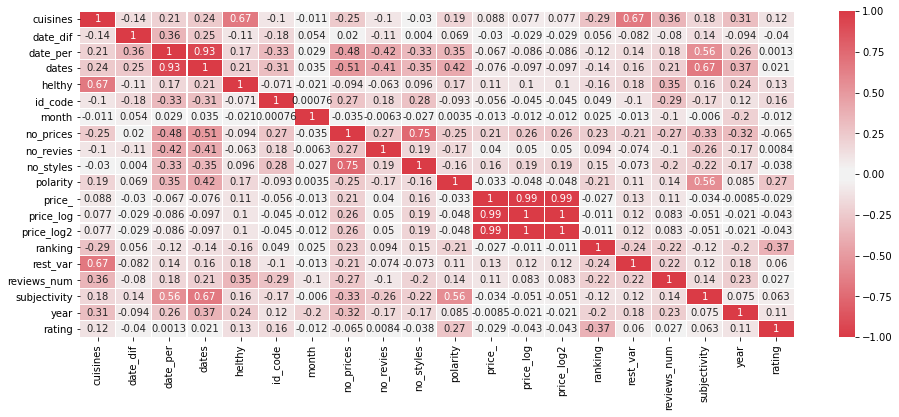

In [56]:
corr_heat(df)

In [57]:
df = df[['restaurant_id', 'id_ta', 'id_code',
         'city', 'country', 'cuisines', 'rest_var', 'helthy', 'cuisine_style', 
         'price_', 'price_log', 'price_log2',
         'reviews_num',
         'reviews', 'polarity', 'subjectivity', 
         'dates', 'date1', 'date2','date_dif', 'date_per', 'month', 'yeartime', 'year',
         'url_ta', 'ranking', 'rating',
         'no_revies', 'no_prices','no_styles']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   restaurant_id  39980 non-null  object        
 1   id_ta          39980 non-null  object        
 2   id_code        39980 non-null  int64         
 3   city           39980 non-null  object        
 4   country        39980 non-null  object        
 5   cuisines       39980 non-null  int64         
 6   rest_var       39980 non-null  int64         
 7   helthy         39980 non-null  int64         
 8   cuisine_style  39980 non-null  object        
 9   price_         39980 non-null  int64         
 10  price_log      39980 non-null  float64       
 11  price_log2     39980 non-null  float64       
 12  reviews_num    39980 non-null  uint16        
 13  reviews        39980 non-null  object        
 14  polarity       39980 non-null  float64       
 15  subjectivity   3998

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

"Нормализуем" векторы "количество отзывов" и "ранг"

In [59]:
df['normal_reviews'] = -1
df['normal_rank'] = -1

for city in df.city.unique():
    df_ = df.loc[df.city == city].copy()
    scaler_s = StandardScaler()
    res = np.array(scaler_s.fit_transform(np.array(df_.reviews_num).reshape(-1, 1)))
    df.loc[df.city == city, 'normal_reviews'] = pd.Series(res.flatten(), df_.index)

    res = np.array(scaler_s.fit_transform(np.array(df_.ranking).reshape(-1, 1)))
    df.loc[df.city == city, 'normal_rank'] = pd.Series(res.flatten(), df_.index)
    
    

In [60]:
df = df[['restaurant_id', 'id_ta', 'id_code',
         'city', 'country', 'cuisines', 'rest_var', 'helthy', 'cuisine_style', 
         'price_', 'price_log', 'price_log2', 
         'reviews_num', 'normal_reviews', 
         'reviews', 'polarity', 'subjectivity', 
         'dates', 'date1', 'date2','date_dif', 'date_per', 'month', 'yeartime', 'year',
         'url_ta',
         'ranking', 'normal_rank',
         'rating',
         'no_revies', 'no_prices','no_styles']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   restaurant_id   39980 non-null  object        
 1   id_ta           39980 non-null  object        
 2   id_code         39980 non-null  int64         
 3   city            39980 non-null  object        
 4   country         39980 non-null  object        
 5   cuisines        39980 non-null  int64         
 6   rest_var        39980 non-null  int64         
 7   helthy          39980 non-null  int64         
 8   cuisine_style   39980 non-null  object        
 9   price_          39980 non-null  int64         
 10  price_log       39980 non-null  float64       
 11  price_log2      39980 non-null  float64       
 12  reviews_num     39980 non-null  uint16        
 13  normal_reviews  39980 non-null  float64       
 14  reviews         39980 non-null  object        
 15  po

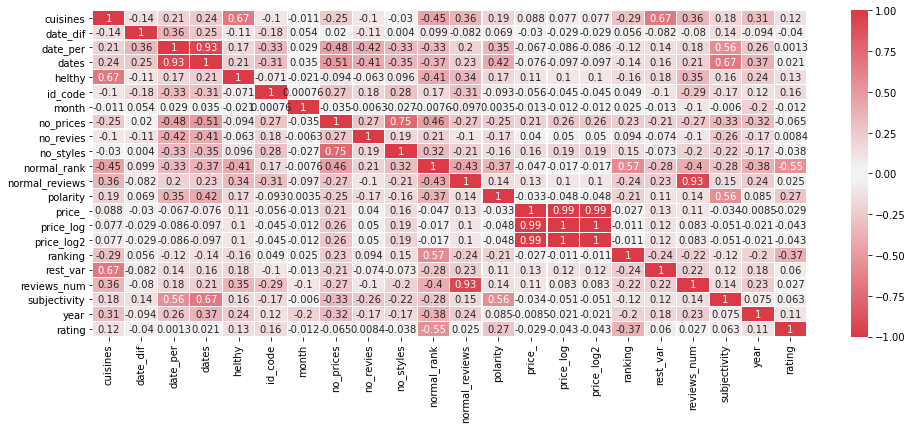

In [61]:
corr_heat(df)

# # MAE & FE

In [62]:
df.date1.fillna(0, inplace=True)
df.date2.fillna(0, inplace=True)
df.month.fillna(0, inplace=True)
df.year.fillna(0, inplace=True)
df.yeartime.fillna(0, inplace=True)
df.isna().sum()

restaurant_id     0
id_ta             0
id_code           0
city              0
country           0
cuisines          0
rest_var          0
helthy            0
cuisine_style     0
price_            0
price_log         0
price_log2        0
reviews_num       0
normal_reviews    0
reviews           0
polarity          0
subjectivity      0
dates             0
date1             0
date2             0
date_dif          0
date_per          0
month             0
yeartime          0
year              0
url_ta            0
ranking           0
normal_rank       0
rating            0
no_revies         0
no_prices         0
no_styles         0
dtype: int64

,object,drop,MAE_0,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
0,restaurant_id,,ci_Krakow,ci_Ljubljana,ranking,ci_Helsinki,ci_Edinburgh,ci_Lisbon
1,id_ta,,year,ci_Madrid,ci_Barcelona,ci_Vienna,month,ci_Copenhagen
2,city,,ci_Zurich,ci_Prague,normal_reviews,ci_Warsaw,subjectivity,rating
3,country,,helthy,ci_Amsterdam,ci_Brussels,ci_Oporto,dates,
4,cuisine_style,,ci_Rome,ci_Budapest,polarity,ci_Oslo,date_per,
5,reviews,,ci_Munich,price_,rest_var,ci_Geneva,id_code,
6,date1,,reviews_num,ci_Milan,price_log,ci_London,no_revies,
7,date2,,ci_Lyon,price_log2,ci_Athens,ci_Stockholm,cuisines,
8,yeartime,,date_dif,ci_Berlin,no_styles,normal_rank,no_prices,
9,url_ta,,ci_Dublin,ci_Bratislava,ci_Paris,ci_Hamburg,ci_Luxembourg,


 MAE : 0.20155927963981993, MAE_rounded: 0.16588294147073537


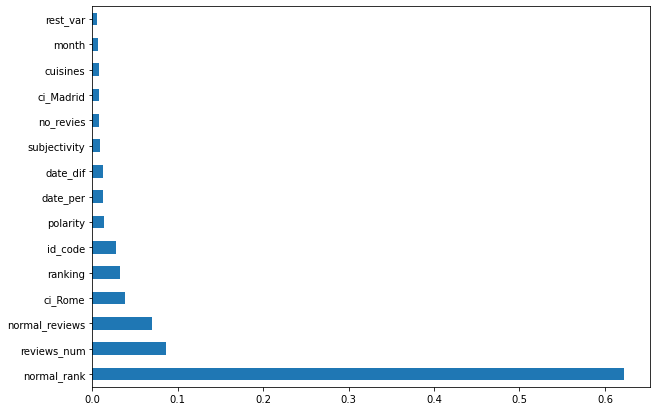

In [63]:
df1=df.copy()
df1 = dum_on(df1,'city')

test_vector(df1,[])
#  MAE : 0.2017298649324662, MAE_rounded: 0.16543271635817908
#  MAE : 0.20155927963981993, MAE_rounded: 0.16588294147073537

In [64]:
# Добавим векторы 
df['reviews_sum'] = np.nan                                          # сумма ревью по городу
df.reviews_sum = df.groupby('city').reviews_num.transform('sum')
df['reviews_rate'] = df.reviews_num / df.reviews_sum                # доля ревью по ресторану от суммы по городу

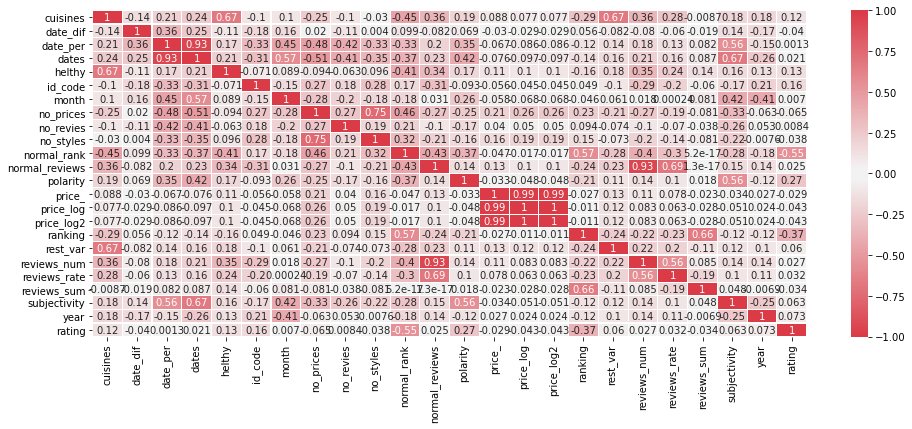

In [65]:
corr_heat(df)

,object,drop,MAE_0,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
0,restaurant_id,reviews_rate,ci_Krakow,ci_Ljubljana,ci_Barcelona,ci_Helsinki,ci_Hamburg,ci_Luxembourg
1,id_ta,,year,ci_Madrid,normal_reviews,ci_Vienna,ci_Edinburgh,ci_Lisbon
2,city,,ci_Zurich,ci_Prague,ci_Brussels,ci_Warsaw,month,ci_Budapest
3,country,,helthy,ci_Amsterdam,polarity,ci_Oporto,dates,rating
4,cuisine_style,,ci_Rome,price_,rest_var,ci_Oslo,date_per,
5,reviews,,ci_Munich,ci_Milan,reviews_sum,ci_Geneva,subjectivity,
6,date1,,reviews_num,price_log2,price_log,ci_London,id_code,
7,date2,,ci_Lyon,ci_Berlin,ci_Athens,ci_Copenhagen,no_revies,
8,yeartime,,date_dif,ci_Bratislava,no_styles,ci_Stockholm,no_prices,
9,url_ta,,ci_Dublin,ranking,ci_Paris,normal_rank,cuisines,


 MAE : 0.20094747373686841, MAE_rounded: 0.16508254127063532


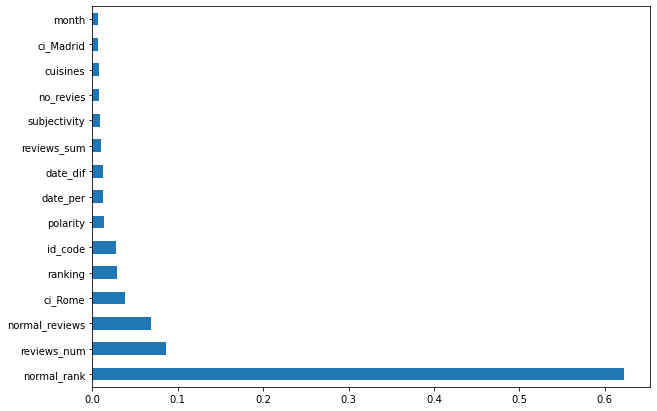

In [68]:
df1=df.copy()
df1 = dum_on(df1,'city')

test_vector(df1,['reviews_rate'])
#  MAE : 0.2013171585792896, MAE_rounded: 0.16528264132066034           'reviews_sum'
# MAE : 0.20125512756378186, MAE_rounded: 0.1655327663831916
# MAE : 0.20163181590795395, MAE_rounded: 0.16548274137068533           'reviews_sum'
# MAE : 0.20094747373686841, MAE_rounded: 0.16508254127063532            'reviews_rate'

Вектор "reviews_rate" оказался менее полезным для модели, так что его пока исключим

In [70]:
df.drop(['reviews_rate'], axis=1, inplace=True)

In [71]:
# Добавим вектор "количество злачных мест в городе" - places_city
df['places_city'] = np.nan
df.places_city = df.groupby('city').id_ta.transform('count')

,object,drop,MAE_0,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
0,restaurant_id,,ci_Krakow,ci_Ljubljana,ranking,ci_Paris,normal_rank,cuisines
1,id_ta,,year,ci_Madrid,ci_Barcelona,ci_Helsinki,ci_Hamburg,ci_Luxembourg
2,city,,ci_Zurich,ci_Prague,normal_reviews,ci_Vienna,ci_Edinburgh,ci_Lisbon
3,country,,helthy,ci_Amsterdam,ci_Brussels,ci_Warsaw,month,ci_Budapest
4,cuisine_style,,ci_Rome,places_city,polarity,ci_Oporto,dates,rating
5,reviews,,ci_Munich,price_,rest_var,ci_Oslo,date_per,
6,date1,,reviews_num,ci_Milan,reviews_sum,ci_Geneva,subjectivity,
7,date2,,ci_Lyon,price_log2,price_log,ci_London,id_code,
8,yeartime,,date_dif,ci_Berlin,ci_Athens,ci_Copenhagen,no_revies,
9,url_ta,,ci_Dublin,ci_Bratislava,no_styles,ci_Stockholm,no_prices,


 MAE : 0.20109504752376184, MAE_rounded: 0.1648824412206103


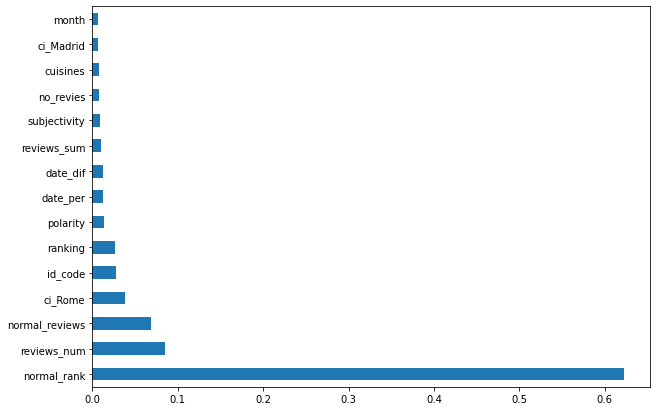

In [73]:
df1=df.copy()
df1 = dum_on(df1,'city')

test_vector(df1,[])  #'price_', 'no_styles'
#   MAE : 0.2013171585792896, MAE_rounded: 0.16528264132066034            'reviews_sum', 'places_city'
#  МАЕ : 0.20174287143571787, MAE_rounded: 0.16578289144572286             'reviews_sum', 'places_city'
#  MAE : 0.20109504752376184, MAE_rounded: 0.1648824412206103

In [74]:
# Добавим вектор "
df['cuisines_city'] = np.nan
#df.cuisines_city = df.groupby('city').cuisines.transform('mean')

In [75]:
# Посчитаем широту представленности кухонь в каждом городе и создадим словарь
cuisines_in_place = {}
cities=df.city.unique().tolist()
for city in cities:
    add = len(df[df.city == city].cuisine_style.explode().value_counts().index.tolist())
    cuisines_in_place.update({city: add})
df.cuisines_city = df.city.map(cuisines_in_place)

,object,drop,MAE_0,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
0,restaurant_id,cuisines_city,ci_Krakow,ci_Dublin,ci_Bratislava,no_styles,ci_Copenhagen,no_revies
1,id_ta,dates,year,ci_Ljubljana,ranking,ci_Paris,ci_Stockholm,no_prices
2,city,,ci_Zurich,ci_Madrid,ci_Barcelona,ci_Helsinki,normal_rank,cuisines
3,country,,helthy,ci_Prague,normal_reviews,ci_Vienna,ci_Hamburg,ci_Luxembourg
4,cuisine_style,,ye_spring,ci_Amsterdam,ci_Brussels,ye_autumn,ci_Edinburgh,ci_Lisbon
5,reviews,,ci_Rome,places_city,polarity,ci_Warsaw,month,ye_no
6,date1,,ci_Munich,price_,rest_var,ci_Oporto,ye_winter,ye_summer
7,date2,,reviews_num,ci_Milan,reviews_sum,ci_Oslo,date_per,ci_Budapest
8,yeartime,,ci_Lyon,price_log2,price_log,ci_Geneva,subjectivity,rating
9,url_ta,,date_dif,ci_Berlin,ci_Athens,ci_London,id_code,


 MAE : 0.20103001500750375, MAE_rounded: 0.1647823911955978


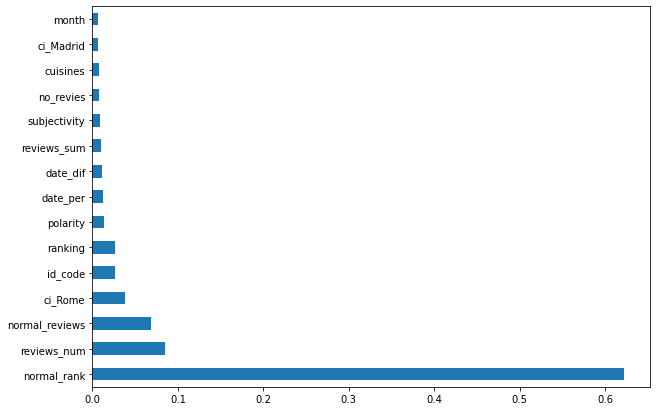

In [86]:
df1=df.copy()
df1 = dum_on(df1,'city')   
df1 = dum_on(df1,'yeartime') # MAE_rounded: 0.1655327663831916  vc 0.16418209104552275

test_vector(df1,['cuisines_city', 'dates'])
# MAE : 0.2010670335167584, MAE_rounded: 0.1656328164082041
# MAE : 0.20101900950475238, MAE_rounded: 0.16543271635817908   'dates', 'no_styles'
# MAE : 0.20047423711855927, MAE_rounded: 0.16418209104552275   'dates', 'no_styles', 'subjectivity'
# MAE : 0.20058129064532265, MAE_rounded: 0.16493246623...   'dates', 'no_styles', 'subjectivity', 'price_log2'
# MAE : 0.20065932966483244, MAE_rounded: 0.1643821910....  'dates', 'no_styles', 'subjectivity', 'price_'
# MAE : 0.20084592296148074, MAE_rounded: 0.1655327663...   'dates', 'no_styles', 'subjectivity', 'price_', 'price_log'
# MAE : 0.20283091545772888, MAE_rounded: 0.1676838419...   'dates', 'no_styles', 'subjectivity', 'no_revies'

# MAE : 0.20054627313656828, MAE_rounded: 0.16523261630815408    'dates', 'no_styles', 'subjectivity'
# MAE : 0.20090495247623813, MAE_rounded: 0.1657328664332166
# MAE : 0.20109504752376184, MAE_rounded: 0.1648824412206103      'cuisines_city'
# MAE : 0.20103001500750375, MAE_rounded: 0.1647823911955978       'cuisines_city', 'dates'        dum 'yeartime'

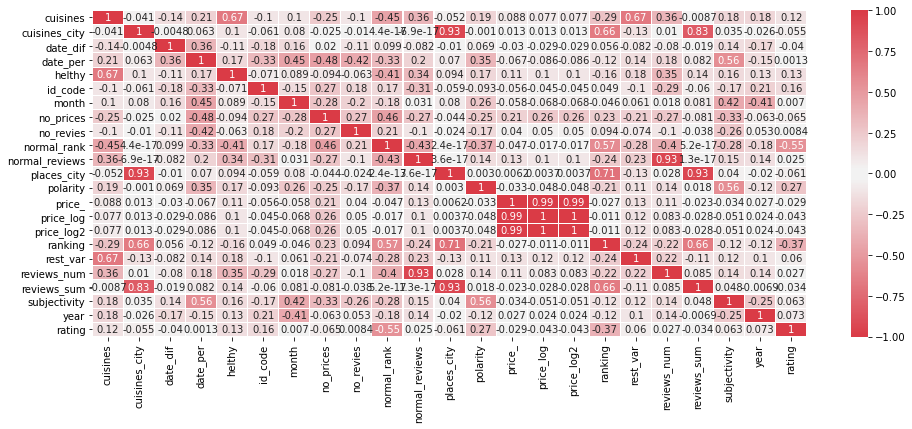

In [79]:
#df.drop(['places_city', 'reviews_sum'], axis=1, inplace=True)
corr_heat(df, ['no_styles', 'dates'])

In [220]:
#df['normal_rev_sub'] = df.reviews_num / df.subjectivity
#df.normal_rev_sub = df.normal_rev_sub.astype('float32')
df.drop('ranking_city', axis=1, inplace=True)

In [218]:
# Добавим вектор "сумма рангов города" - ranking_city
df['ranking_city'] = np.nan
df.ranking_city = df.groupby('city').ranking.transform('mean')

# Нудачи
- - - 

Было много векторов, которые в итоге не пошли в модель. Их я удалил, чтобы не засорять код. Надо сказать, что ни страна, ни время года не принесли видимого результата для модели.  
Страна, пожалуй, только позволила создавать  новые вектора на основе  аггрегирования для сумм или подсчета количества.  

# что не удалось

Жаль, что не удалось запустить функцию TextBlob, для анализа на позитивность и негативность. А создавать свою на основе ручного сета слов, у меня не хватило желания.  

Все еще не доволен я чистотой кода, синтаксис - это наверняка то, что тут много где можно поправить.

# Неожиданно.

Вектор resaurant_id это почти 100% реплика вектора ranking. Точнее, наверное нужно скзать, что РАНГ - это реплика вектора КОД_РЕСТОРАНА. Более чем в 2/3 случаев они отличаются на 1-2 пункта. А корреляция этих векторов равна 1. Понятно, что c этим вектором нам ничего не светит для модели. Но как он тут оказался - загадка! 

In [127]:
# импортирую библиотеку
!pip install textblob

In [179]:
# функция зависает так на долго, что я не дождался ее выполнения, В итоговой модели не участвует
def rev_analise2(to_analise):
    #blob = TextBlob(to_analise)
    #pol = blob.sentiment.polarity
    #sub = blob.sentiment.subjectivity

    blob = TextBlob(to_analise, analyzer=NaiveBayesAnalyzer())
    test, p_pos, p_neg = blob.sentiment
    return pd.Series([test, p_pos, p_neg ])

In [134]:
import nltk
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\SkillFactory\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


True

In [138]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SkillFactory\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True